In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

C:\Users\spark\AppData\Local\Temp\ipykernel_25096\3577331749.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
window_size = 10
batch_size_exp = 10
epoch_exp = 60
neurons_exp = 5
predict_values_exp = 30
lag_exp=72

In [3]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
def scale(data_norm):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(data_norm)
    # transform train
    data_norm = data_norm.reshape(data_norm.shape[0], data_norm.shape[1])
    data_scaled = scaler.transform(data_norm)
    return scaler, data_scaled

In [7]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
     

In [8]:
from keras.layers import Activation, Dense, BatchNormalization, TimeDistributed
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    print(X.shape, y.shape)
    model = Sequential()
    model.add(LSTM(neurons_exp))
    model.add(BatchNormalization())
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [9]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=batch_size_exp)
    return yhat[0,0]

In [10]:
df = pd.read_csv("dataset.csv", index_col = "DATE")
df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,FMTM,PGTM,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,city,state,region,th_power,power
DATE,,,,,,,,,,,,,,,,,,,,
2010-01-01,USW00014942,"OMAHA EPPLEY AIRFIELD, NE US",41.31186,-95.90186,298.8,3.800000,1311.000000,1159.000000,11.426918,-11.100000,-23.300000,350.000000,330.000000,8.000000,10.300000,Des Moines,IA,Midwest Region,105682.164827,0
2010-01-02,USW00014942,"OMAHA EPPLEY AIRFIELD, NE US",41.31186,-95.90186,298.8,1.700000,222.000000,1950.000000,11.426918,-16.700000,-25.600000,10.000000,30.000000,5.400000,7.200000,Des Moines,IA,Midwest Region,9462.320961,0
2010-01-03,USW00014942,"OMAHA EPPLEY AIRFIELD, NE US",41.31186,-95.90186,298.8,2.400000,1547.000000,1558.000000,11.426918,-13.300000,-20.600000,10.000000,20.000000,5.400000,5.800000,Des Moines,IA,Midwest Region,26624.694682,0
2010-01-04,USW00014942,"OMAHA EPPLEY AIRFIELD, NE US",41.31186,-95.90186,298.8,2.700000,1606.000000,1605.000000,11.426918,-15.600000,-28.900000,10.000000,10.000000,4.000000,4.500000,Des Moines,IA,Midwest Region,37908.989107,0
2010-01-05,USW00014942,"OMAHA EPPLEY AIRFIELD, NE US",41.31186,-95.90186,298.8,1.300000,2219.000000,2221.000000,11.426918,-13.300000,-26.700000,150.000000,140.000000,3.600000,4.000000,Des Moines,IA,Midwest Region,4231.369663,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-03,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",35.22254,-80.95433,222.6,4.300000,1836.559043,1424.130094,14.700000,21.100000,8.900000,310.000000,270.000000,10.700000,15.700000,Charleston,SC,Coastal Areas,153128.587967,0
2023-05-04,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",35.22254,-80.95433,222.6,2.600000,1836.559043,1424.130094,14.800000,22.800000,6.700000,270.000000,10.000000,5.800000,8.100000,Charleston,SC,Coastal Areas,33850.957301,0
2023-05-05,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",35.22254,-80.95433,222.6,2.500000,1836.559043,1424.130094,17.200000,23.900000,11.700000,220.000000,230.000000,5.400000,6.300000,Charleston,SC,Coastal Areas,30093.377778,0


In [11]:
temp = df[['power']]
temp

,power
DATE,
2010-01-01,0
2010-01-02,0
2010-01-03,0
2010-01-04,0
2010-01-05,0
...,...
2023-05-03,0
2023-05-04,0
2023-05-05,0


In [12]:
temp_df = df[df['STATION'].isin({'USW00023047'})]
temp = temp_df[['AWND']]
temp

,AWND
DATE,
2010-01-01,4.700000
2010-01-02,4.700000
2010-01-03,3.600000
2010-01-04,2.500000
2010-01-05,6.100000
...,...
2023-05-03,7.200000
2023-05-04,5.700000
2023-05-05,6.800000


In [13]:
temp.shape

(4875, 1)

In [14]:
raw_values = temp.values
diff_values = difference(raw_values, 1)

In [15]:
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [16]:
scaler,supervised_values = scale(supervised_values)
train_scaled, test_scaled = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]
train_scaled.shape

(4844, 73)

In [17]:
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

(4844, 1, 72) (4844,)
485/485 [==============================] - 1s 2ms/step - loss: 0.0264


In [18]:
predictions = list()
expectations = list()
test_pred = list()
for i in range(len(test_scaled)-window_size):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, batch_size_exp, X)
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1> lag_exp+1:
            test_scaled[i+1] = test_pred
    else:
        test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train_scaled) + i + 1]
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 265ms/step
Day=1, Predicted=5.882948, Expected=5.300000
1/1 [==============================] - 0s 14ms/step
Day=2, Predicted=4.654032, Expected=5.100000
1/1 [==============================] - 0s 15ms/step
Day=3, Predicted=7.891101, Expected=3.200000
1/1 [==============================] - 0s 15ms/step
Day=4, Predicted=7.786526, Expected=5.800000
1/1 [==============================] - 0s 16ms/step
Day=5, Predicted=2.263275, Expected=9.900000
1/1 [==============================] - 0s 16ms/step
Day=6, Predicted=9.135290, Expected=9.300000
1/1 [==============================] - 0s 16ms/step
Day=7, Predicted=6.442272, Expected=7.400000
1/1 [==============================] - 0s 16ms/step
Day=8, Predicted=9.419155, Expected=7.300000
1/1 [==============================] - 0s 16ms/step
Day=9, Predicted=7.416479, Expected=3.600000
1/1 [==============================] - 0s 17ms/step
Day=10, Predicted=5.480207, Expected=9.100000
1/1 [=======================

In [19]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations.mean()))*100))
     


Mean Absolute Percent Error:  43.59992311792962


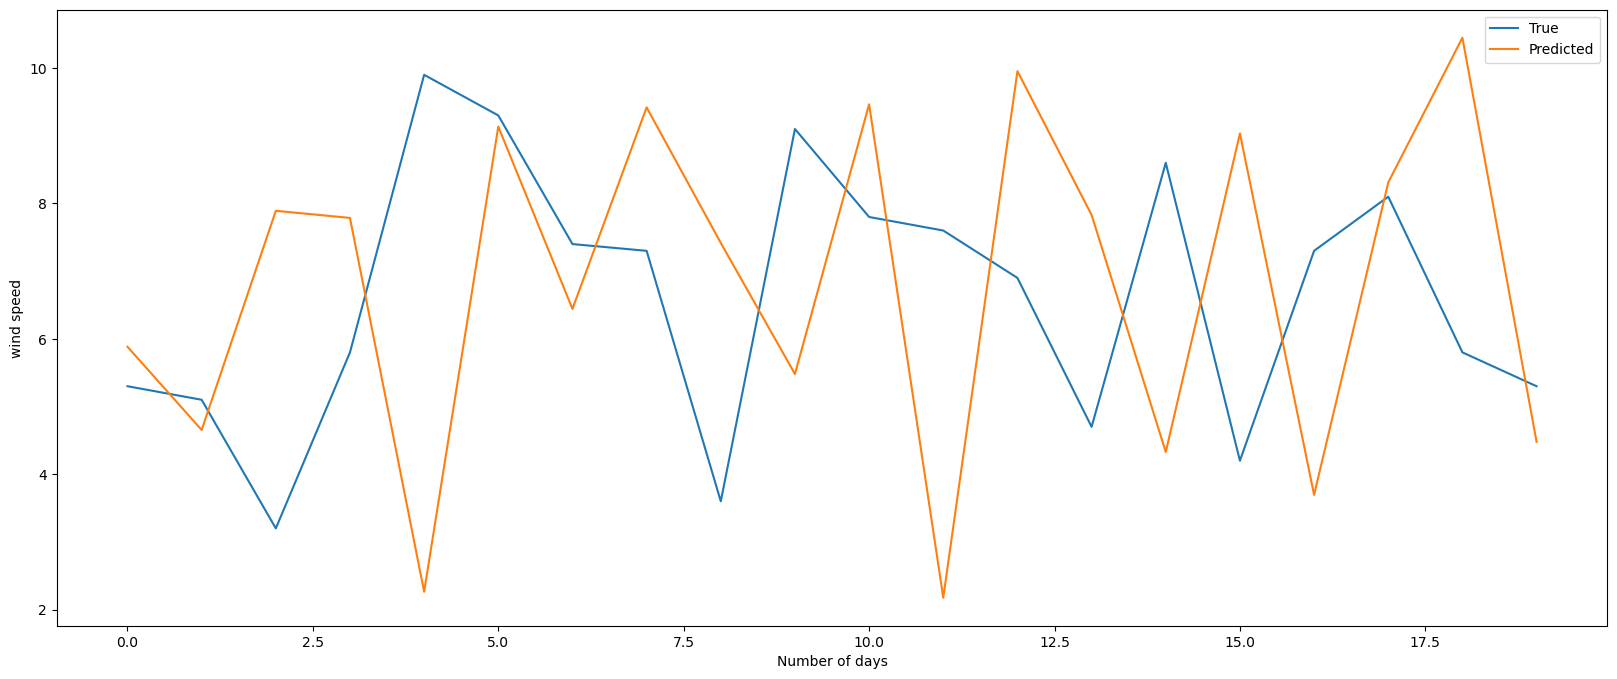

In [20]:
fig = pyplot.figure(figsize=(20,8))
pyplot.plot(expectations, label="True")
pyplot.plot(predictions, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of days")
pyplot.ylabel("wind speed")
pyplot.show()

In [21]:
import pickle 
Pkl_Filename = "Pickle_RL1_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lstm_model, file)
    
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR1_Model = pickle.load(file)

Pickled_LR1_Model

In [22]:
from copy import deepcopy

X, y = supervised_values[:, 0:-1], supervised_values[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])

q_80 = int(len(temp) * .93)
q_90 = int(len(temp) * .97)

X_train, y_train =  X[:q_80], y[:q_80]

X_val, y_val = X[q_80:q_90], y[q_80:q_90]
X_test, y_test = X[q_90:], y[q_90:]
# xval = X_val.shape[0]
# X_val = xval
# xtest = X_test.shape[0]
# X_test = xtest
X_train.shape, X_val.shape, X_test.shape, temp.shape
recursive_predictions = []
recursive_dates = np.concatenate([X_val, X_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[0])
  next_prediction = lstm_model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 16ms/step


In [23]:
test_predictions = lstm_model.predict(X_test)

5/5 [==============================] - 0s 1ms/step


In [24]:
val_predictions = lstm_model.predict(X_val)

7/7 [==============================] - 0s 1ms/step


In [25]:
train_predictions = lstm_model.predict(X_train)

142/142 [==============================] - 0s 810us/step


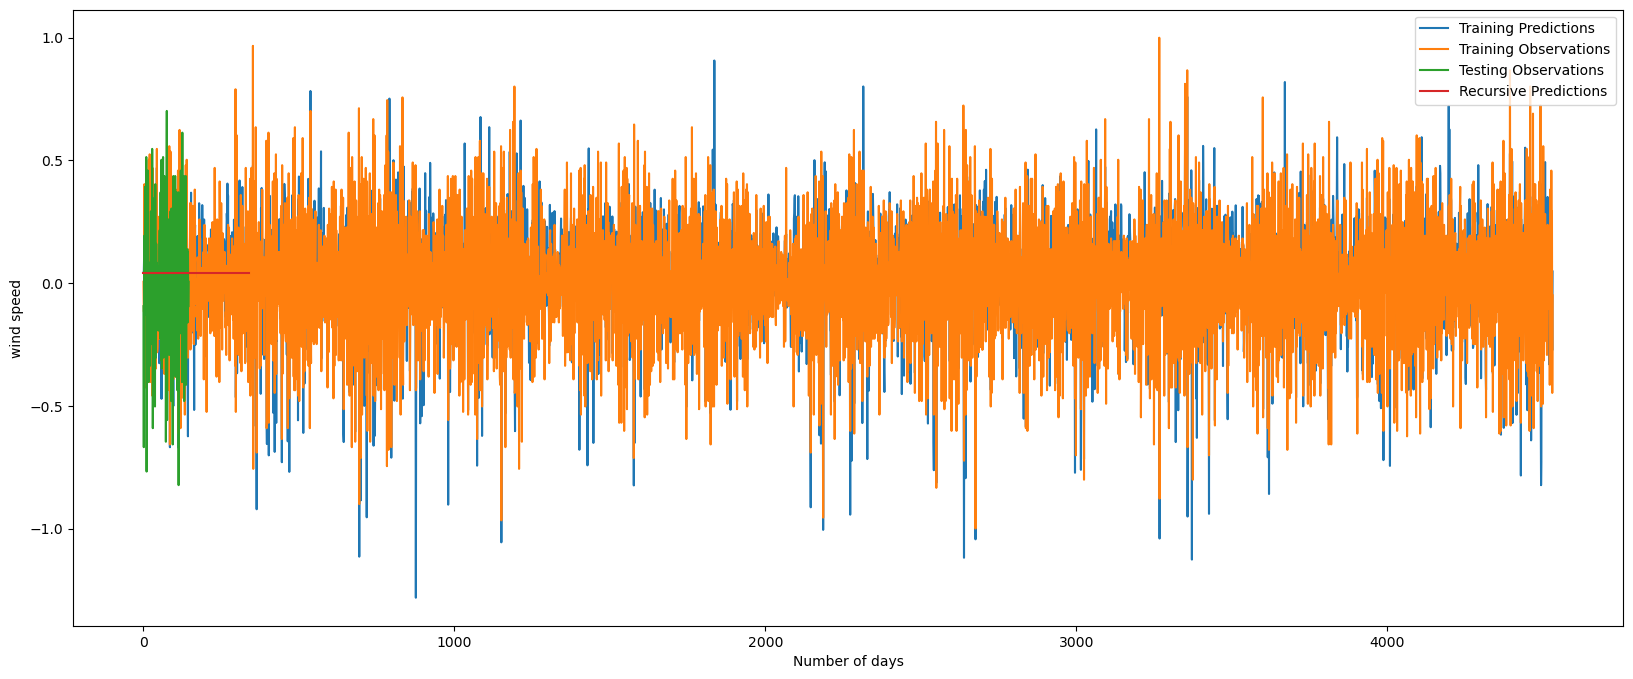

In [28]:
fig = pyplot.figure(figsize=(20,8))
pyplot.plot(train_predictions, label="Training Predictions")
pyplot.plot(y_train, label="Training Observations")
# pyplot.plot(val_predictions, label="Validation Predictions")
# pyplot.plot(y_val, label="Validation Observations")
# pyplot.plot(test_predictions, label="Testing Predictions")
pyplot.plot(y_test, label="Testing Observations")
pyplot.plot(recursive_predictions, label="Recursive Predictions")

pyplot.legend(loc='upper right')
pyplot.xlabel("Number of days")
pyplot.ylabel("wind speed")
pyplot.show()
# plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
# plt.plot(dates_val, val_predictions)
# plt.plot(dates_val, y_val)
# plt.plot(dates_test, test_predictions)
# plt.plot(dates_test, y_test)
# plt.plot(recursive_dates, recursive_predictions)
# plt.legend(['Training Predictions', 
#             'Training Observations',
#             'Validation Predictions', 
#             'Validation Observations',
#             'Testing Predictions', 
#             'Testing Observations',
#             'Recursive Predictions'])